In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import json
import shutil

In [8]:
from tensorflow import constant_initializer

def _exponential_initializer(min, max, dtype=None):
    def in_func(shape, dtype=dtype):
        initializer = tf.random_uniform_initializer(
                        tf.math.log(1.0),
                        tf.math.log(100.0)
                        )
        return tf.math.exp(initializer(shape))
    return in_func

class PhasedLSTM(tf.keras.layers.Layer):
    def __init__(self,
                 units,
                 leak_rate=0.001,
                 ratio_on=0.1,
                 period_init_min=0.0,
                 period_init_max=1000.0,
                 rec_activation = tf.math.sigmoid,
                 out_activation = tf.math.tanh,
                 name='plstm',
                 **kwargs):
        super(PhasedLSTM, self).__init__(name=name)
        
        self.state_size = [units,units] #This change
        self.output_size = units        #This change
        
        self.units = units
        self._leak = leak_rate
        self._ratio_on = ratio_on
        self._rec_activation = rec_activation
        self._out_activation = out_activation
        self.period_init_min = period_init_min
        self.period_init_max = period_init_max
        
        self.cell = tf.keras.layers.LSTMCell(units, **kwargs)

    def _get_cycle_ratio(self, time, phase, period):
        """Compute the cycle ratio in the dtype of the time."""
        phase_casted = tf.cast(phase, dtype=time.dtype)
        period_casted = tf.cast(period, dtype=time.dtype)
        time = tf.reshape(time, [tf.shape(time)[0],1]) #This change
        shifted_time = time - phase_casted
        cycle_ratio = (shifted_time%period_casted) / period_casted
        return tf.cast(cycle_ratio, dtype=tf.float32)        
        
    def build(self, input_shape):
        self.period = self.add_weight(
                        name="period",
                        shape=[self.units],
                        initializer=_exponential_initializer(
                                            self.period_init_min,
                                            self.period_init_max),
                        trainable=True)

        self.phase = self.add_weight(name="phase",
                                     shape=[self.units],
                                     initializer=tf.random_uniform_initializer(
                                                         0.0,
                                                         self.period),
                                     trainable=True)
        self.ratio_on = self.add_weight(name="ratio_on",
                                        shape=[self.units],
                                        initializer=constant_initializer(self._ratio_on),
                                        trainable=True)

    def call(self, input, states):
        inputs, times = input, input[:,0] #This change

        # =================================
        # CANDIDATE CELL AND HIDDEN STATE
        # =================================
        output, (hs, cs) = self.cell(inputs, states)

        # =================================
        # TIME GATE
        # =================================
        cycle_ratio = self._get_cycle_ratio(times, self.phase, self.period)

        k_up = 2 * cycle_ratio / self.ratio_on
        k_down = 2 - k_up
        k_closed = self._leak * cycle_ratio

        k = tf.where(cycle_ratio < self.ratio_on, k_down, k_closed)
        k = tf.where(cycle_ratio < 0.5 * self.ratio_on, k_up, k)

        # =================================
        # UPDATE STATE USING TIME GATE VALUES
        # =================================
        new_h = k * hs + (1 - k) * prev_hs
        new_c = k * cs + (1 - k) * prev_cs

        return new_h, (new_h, new_c)

    
    
class PhasedSNForecastModel(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.d1 = tf.keras.layers.Dropout(0.2)
        self.concat = tf.keras.layers.Concatenate()
        self.mask = tf.keras.layers.Masking(mask_value=-1.0)
        self._init_dense()
        self._init_recurrent()

    def normalization(self,inputs):
        max_all = tf.keras.backend.max(inputs)
        max_val = tf.keras.backend.max(inputs,axis=1)
        min_val = tf.keras.backend.min(tf.where(inputs > -1, inputs, max_all*tf.ones_like(inputs)),axis=1)

        stacked_min_val = tf.stack([min_val for i in range(inputs.shape[1])])
        stacked_min_val = tf.transpose(stacked_min_val, [1, 0, 2])
        stacked_max_val = tf.stack([max_val for i in range(inputs.shape[1])])
        stacked_max_val = tf.transpose(stacked_max_val, [1, 0, 2])

        inputs = (inputs - stacked_min_val) / (stacked_max_val-stacked_min_val)
        return min_val, max_val, inputs

    def denormalize(self,inputs, min_val, max_val):
        stacked_min_val = tf.stack([min_val for i in range(self.out_steps)])
        stacked_min_val = tf.transpose(stacked_min_val, [1, 0, 2])
        stacked_max_val = tf.stack([max_val for i in range(self.out_steps)])
        stacked_max_val = tf.transpose(stacked_max_val, [1, 0, 2])

        inputs = inputs * (stacked_max_val-stacked_min_val) + stacked_min_val
        return inputs

    def fowardpass(self, cells, states, denses, x, training=None):
        for i,cell in enumerate(cells):
            x, states[i] = cell(x, states=states[i],
                      training=training)
        for layer in denses:
            x = layer(x)

        return x, states

    def _warmup(self,rnn, denses, inputs):
        x, *state = rnn(inputs)
        for layer in denses:
            x = layer(x)
        return x, state

    def warmups(self,inputs):
        prediction,states = self._warmup(self.rnn,self.denses,inputs)
        return prediction,states

    def _init_recurrent(self):
        cell1 = PhasedLSTM(self.units, activation="sigmoid", dropout=0.2)
        self.cells = [cell1]
        self.rnn = tf.keras.layers.RNN(self.cells, return_state=True)

    def _init_dense(self):
        dense1 = tf.keras.layers.Dense(self.units//2, activation="sigmoid")
        dense2 = tf.keras.layers.Dense(self.units//4, activation="sigmoid")
        dense3 = tf.keras.layers.Dense(self.units//8, activation="sigmoid")

        out = tf.keras.layers.Dense(2, activation="linear")
        self.denses = [dense1,self.d1,dense2, self.d1,dense3, self.d1,out]

    def call(self, inputs, training=None):
        inputs = self.mask(inputs)
        print(inputs._keras_mask)
        min_val, max_val, inputs =  self.normalization(inputs)
        #Creating empty tensors for predictions
        predictions = []
        prediction, states = self.warmups(inputs)

        #Saving first predictions
        predictions.append(prediction)

        for n in range(1, self.out_steps):
            prediction, states = self.fowardpass(self.cells, states, self.denses, prediction, training)
            predictions.append(prediction)

        #Stacking predictions
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        predictions = self.denormalize(predictions, min_val, max_val)
        return predictions
    

In [9]:
# import sys 
# sys.path.append("../code/")
# from model import SNForecastModel
# from phased_model import PhasedSNForecastModel
out_steps = 10

In [10]:
def loss(y_true,y_pred,output_steps=10):
    maes = []
    for i in range(out_steps):
        maes.append(tf.keras.losses.MAE(y_true[:,i,:],y_pred[:,i,:]))
    maes = tf.stack(maes)
    return tf.reduce_mean(maes,axis=1)

In [11]:
model = PhasedSNForecastModel(units=64, out_steps=out_steps)
losses = [tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)]#"mse"
model.compile(optimizer="adam", loss=losses)

In [12]:
data = np.load("../data/padded_x_train.npy")


len_data = data.shape[1]
X_train, y_train = data[:,:-out_steps,:2],  data[:,-out_steps:,:2]

In [13]:
data_val = np.load("../data/padded_x_val.npy")
len_data = data_val.shape[1]

X_val, y_val = data_val[:,:-out_steps,:2],  data_val[:,-out_steps:,:2]

In [14]:
inputs = X_train
outputs = y_train
inputs_val = X_val
outputs_val = y_val

In [15]:
#Early stops
early_stop = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=1e-8, patience=5)

#Tensorboard
tensorboard = tf.keras.callbacks.TensorBoard("../data/training/logs")
shutil.rmtree("../data/training/logs",ignore_errors=True)
#Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint("../data/training/model_checkpoints/checkpoint", monitor='val_loss', verbose=0, save_best_only=True)

callbacks = [tensorboard,checkpoint, early_stop] # mag_early_stop,fid_early_stop,dt_early_stop,

In [16]:
MAX_EPOCHS=1000
history = model.fit(inputs,outputs,
                    batch_size=300, 
                    epochs=MAX_EPOCHS, 
                    validation_data=(inputs_val,outputs_val), 
                    callbacks=callbacks)

Epoch 1/1000
Tensor("phased_sn_forecast_model/masking/Squeeze:0", shape=(None, 79), dtype=bool)


NameError: in user code:

    /home/camilo/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    <ipython-input-8-0b67a7d306b8>:168 call  *
        prediction, states = self.warmups(inputs)
    <ipython-input-8-0b67a7d306b8>:146 warmups  *
        prediction,states = self._warmup(self.rnn,self.denses,inputs)
    <ipython-input-8-0b67a7d306b8>:140 _warmup  *
        x, *state = rnn(inputs)
    <ipython-input-8-0b67a7d306b8>:90 call  *
        new_h = k * hs + (1 - k) * prev_hs

    NameError: name 'prev_hs' is not defined


In [ ]:
history_dict = history.history
json.dump(history_dict, open("../data/training/history_model.json", 'w'))

In [11]:
model.save_weights("../data/sn_model.h5")

In [12]:
data_test = np.load("../data/padded_x_val.npy")

In [13]:
X_test, y_test = data_test[:,:-out_steps,:2], data_test[:,-out_steps:, :2]

In [14]:
y_hat = model.predict(X_test)

In [15]:
maes = []
for i in range(out_steps):
    maes.append(mean_absolute_error(y_test[:,i,:], y_hat[:,i,:]))

Text(0.5, 1.0, 'MAE on Test')

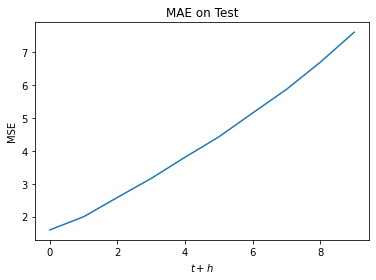

In [16]:
plt.plot(maes)
plt.ylabel("MSE")
plt.xlabel("$t+h$")
plt.title("MAE on Test")

In [17]:
y_hat_train = model.predict(X_train)

In [18]:
maes_train = []
for i in range(out_steps):
    maes_train.append(mean_absolute_error(y_train[:,i,:], y_hat_train[:,i,:]))

Text(0.5, 1.0, 'MAE on Train')

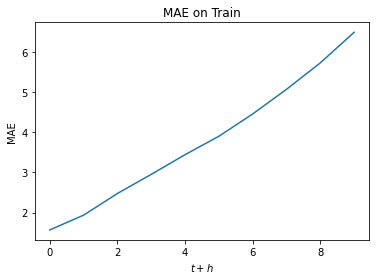

In [19]:
plt.plot(maes_train)
plt.ylabel("MAE")
plt.xlabel("$t+h$")
plt.title("MAE on Train")